 # **Project Title**: Face Detection and Recognition Model Implementation

## **Problem Statement**:
Develop and integrate a face detection and recognition system using a machine learning approach. The system should accurately detect and recognize faces in images, leveraging the Labeled Faces in the Wild (LFW) dataset.

Model Accuracy: 0.64


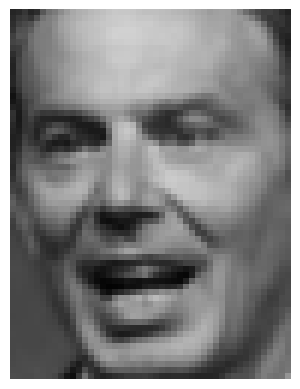

In [5]:
# Install necessary packages
!pip install opencv-python-headless dlib scikit-learn

import urllib.request
import bz2
import shutil
import dlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2

# Download the Dlib shape predictor and face recognition model files
def download_dlib_models():
    urllib.request.urlretrieve('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2', 'shape_predictor_68_face_landmarks.dat.bz2')
    with bz2.BZ2File('shape_predictor_68_face_landmarks.dat.bz2') as fr, open('shape_predictor_68_face_landmarks.dat', 'wb') as fw:
        shutil.copyfileobj(fr, fw)

    urllib.request.urlretrieve('http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2', 'dlib_face_recognition_resnet_model_v1.dat.bz2')
    with bz2.BZ2File('dlib_face_recognition_resnet_model_v1.dat.bz2') as fr, open('dlib_face_recognition_resnet_model_v1.dat', 'wb') as fw:
        shutil.copyfileobj(fr, fw)

# Download Dlib models
download_dlib_models()

# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5, download_if_missing=True)

# Initialize Dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

# Function to detect faces
def detect_faces(image):
    if len(image.shape) == 3:  # If the image has 3 channels (RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # Image is already in grayscale

    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)

    faces = detector(image)

    for face in faces:
        x, y, w, h = (face.left(), face.top(), face.width(), face.height())
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.show()

# Function to extract face embeddings
def get_face_embeddings(images, labels):
    embeddings = []
    valid_labels = []
    for img, label in zip(images, labels):
        if len(img.shape) == 2:  # If the image is grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        faces = detector(img)
        for face in faces:
            shape = sp(img, face)
            face_descriptor = facerec.compute_face_descriptor(img, shape)
            embeddings.append(face_descriptor)
            valid_labels.append(label)
    return np.array(embeddings), np.array(valid_labels)

# Extract face embeddings and labels
embeddings, labels = get_face_embeddings(lfw_people.images, lfw_people.target)

# Train a classifier
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)

# Use a more complex classifier and tune hyperparameters
clf = SVC(kernel='linear', C=1.0, probability=True)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Function for face recognition
def recognize_faces(image, model):
    if len(image.shape) == 2:  # If the image is grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    faces = detector(image)
    for face in faces:
        shape = sp(image, face)
        face_descriptor = facerec.compute_face_descriptor(image, shape)
        face_descriptor = np.array(face_descriptor).reshape(1, -1)

        identity = model.predict(face_descriptor)

        x, y, w, h = (face.left(), face.top(), face.width(), face.height())
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, lfw_people.target_names[identity[0]], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.show()

# Example usage
recognize_faces(lfw_people.images[1], clf)
